### Inference and Validation

After the model is trained, it can use it for making predictions. This is typically called inference. However, neural networks have a tendency to perform too well on the training data and arent able to generalize to data that hasnot been seen before. This phenomenon is called overfitting and it impairs inference performance.

To overcome overfitting, we measure the performance on data not in the training set called the validation set. We overcome overfitting through regularization such as dropout while monitoring the validation performance during training.

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)
print("Success")


Success


In [2]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim = 1)
        
        return x

The goal of validation is to measure the model's performance on data that isnot part of the training set.

In [3]:
model = Classifier()

images, labels = next(iter(testloader))

# get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 example
print(ps.shape)
# 64 rows 10 columns

torch.Size([64, 10])


With the probabilities we can get the most likely class using the ps.topk method. This returns the k highest values. Since we just want the most likely class, we can use ps.topk(1). This return a tuple of the top-k values and top -k indies. If the highest value is 5th elementm we will get back 4 as index

In [9]:
top_p, top_class = ps.topk(1, dim=1)
print(top_class[:10, :])
# selecting the first 10 values of the row from the columns

tensor([[7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [1]])
tensor([[7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [1],
        [7],
        [7],
        [7],
        [7],
        [1],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [7],
        [1],
        [7]])


Now we can check if the predicted classes match the labels. This is simple to do by just equating top_class and labels, but we have to be careful of the shapes. Here top_class is 2D tensore with shape(64,1) while labels is 1D with shape(64). to get the equality to work out the way we want, top_class and labels must have the same shape

In [15]:
equals = top_class == labels.view(*top_class.shape)
print(labels.view(*top_class.shape).shape)

torch.Size([64, 1])


Now we need to calculate the percentage of correct predictions. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions.  Its like taking a mean of the values. 
torch.mean(equal) will result in  a runtime error

This happens because equals has type torch.ByteTensor but torch.mean isnt implemented for tensors with that type. So you will need to convert equals to a float tensor. 

In [16]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy : {accuracy.item() * 100}%')

Accuracy : 10.9375%


Since below we are not doing any updation of the weights during the validation hence turnign of the gradients

In [17]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy =0
        
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                test_loss += loss
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim =1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy +=torch.mean(equals.type(torch.FloatTensor))
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
            
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Epoch: 1/30..  Training Loss: 0.509..  Test Loss: 0.444..  Test Accuracy: 0.841
Epoch: 2/30..  Training Loss: 0.393..  Test Loss: 0.405..  Test Accuracy: 0.854
Epoch: 3/30..  Training Loss: 0.357..  Test Loss: 0.391..  Test Accuracy: 0.860
Epoch: 4/30..  Training Loss: 0.337..  Test Loss: 0.384..  Test Accuracy: 0.861
Epoch: 5/30..  Training Loss: 0.315..  Test Loss: 0.380..  Test Accuracy: 0.868
Epoch: 6/30..  Training Loss: 0.306..  Test Loss: 0.382..  Test Accuracy: 0.862
Epoch: 7/30..  Training Loss: 0.293..  Test Loss: 0.371..  Test Accuracy: 0.872
Epoch: 8/30..  Training Loss: 0.285..  Test Loss: 0.349..  Test Accuracy: 0.876
Epoch: 9/30..  Training Loss: 0.272..  Test Loss: 0.369..  Test Accuracy: 0.876
Epoch: 10/30..  Training Loss: 0.265..  Test Loss: 0.382..  Test Accuracy: 0.875
Epoch: 11/30..  Training Loss: 0.257..  Test Loss: 0.378..  Test Accuracy: 0.873
Epoch: 12/30..  Training Loss: 0.251..  Test Loss: 0.375..  Test Accuracy: 0.881
Epoch: 13/30..  Training Loss: 0.247.

### Overfitting
If we look at the training and validation losses as we train the network, we cna see a phenomenon known as overfitting.

The network overtime learns better and better, resulting in lower training losses.  However it starts having problems generalizing to data outside the training set leading to the validation loss increasing. 

The goal is to make predictions on new data,so we should strive to get the lowest validaton loss possible. 

The most common method to reduce overfitting is dropout, where we randomly drop input units. This forces the network to share information between weights, increasing its ability to generlize to new data. Adding dropout in Pytorch is straightforward using the nn.Dropout module. 

In [18]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

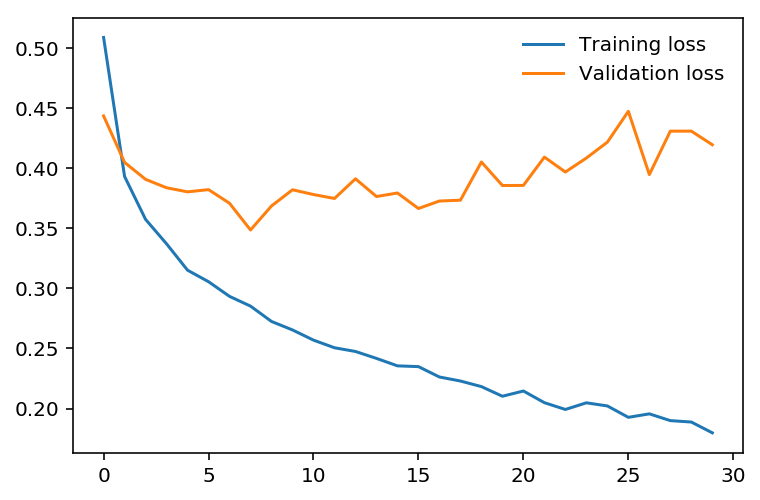

In [19]:

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

During Training we want to use dropout to prevent overfitting, but during inference/prediction we want to use the entire network.. so we need to turn off dropout during validation, testing and whenevr we are using thr network to make predictions. 
To do this we use model.eval().  this sets the model to evaluation mode where the dropout probability is 0. you can turn droput back on by setting the model to train mode with model.train(). 

In [20]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [21]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        # model.eval lets the dropout to 0 during validation
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.605..  Test Loss: 0.483..  Test Accuracy: 0.827
Epoch: 2/30..  Training Loss: 0.485..  Test Loss: 0.436..  Test Accuracy: 0.846
Epoch: 3/30..  Training Loss: 0.453..  Test Loss: 0.427..  Test Accuracy: 0.847
Epoch: 4/30..  Training Loss: 0.436..  Test Loss: 0.428..  Test Accuracy: 0.849
Epoch: 5/30..  Training Loss: 0.422..  Test Loss: 0.400..  Test Accuracy: 0.859
Epoch: 6/30..  Training Loss: 0.411..  Test Loss: 0.404..  Test Accuracy: 0.853
Epoch: 7/30..  Training Loss: 0.399..  Test Loss: 0.399..  Test Accuracy: 0.861
Epoch: 8/30..  Training Loss: 0.396..  Test Loss: 0.387..  Test Accuracy: 0.868
Epoch: 9/30..  Training Loss: 0.392..  Test Loss: 0.389..  Test Accuracy: 0.860
Epoch: 10/30..  Training Loss: 0.386..  Test Loss: 0.392..  Test Accuracy: 0.861
Epoch: 11/30..  Training Loss: 0.388..  Test Loss: 0.410..  Test Accuracy: 0.859
Epoch: 12/30..  Training Loss: 0.377..  Test Loss: 0.379..  Test Accuracy: 0.867
Epoch: 13/30..  Training Loss: 0.379.

In [22]:

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

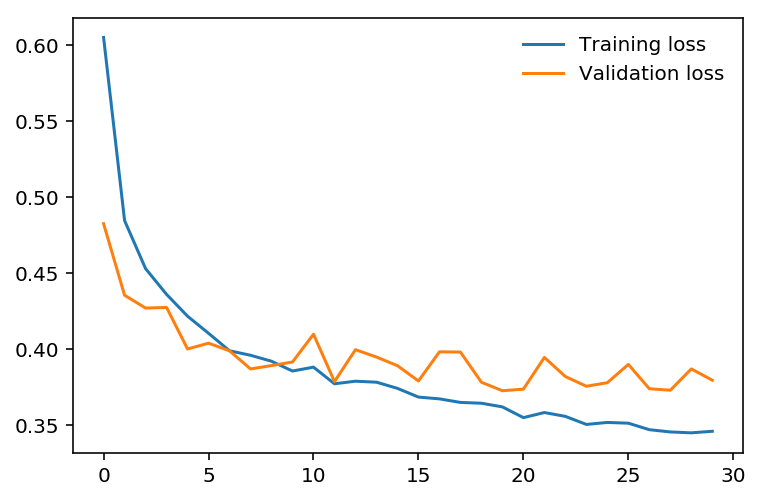

In [23]:

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

### Inference
Now that the model is trained, we can use it for inference. We have done this before, but now we need to remember to set the model in inference mode with model.eval(). You will also want to turn off autograd with torch.no_grad()

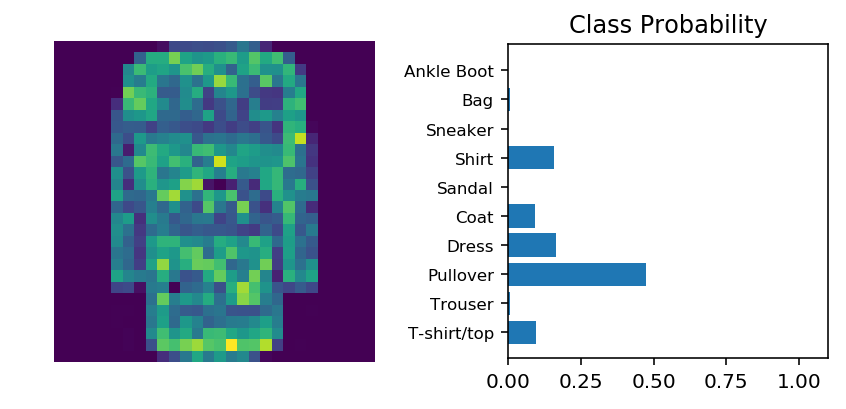

In [24]:
# Import helper module (should be in the repo)
import helper

# Test out your network!
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')